<a href="https://colab.research.google.com/github/bharatsb2004/denoising/blob/main/proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.applications import VGG16
from skimage import io, img_as_float
from skimage.transform import resize
import numpy as np


# Load and preprocess data
def load_data():
    noisy_imgs, clean_imgs = [], []
    for i in range(1, 101):
        noisy_img = img_as_float(io.imread(f'/content/drive/MyDrive/pics/noisy_image/noisy_image{i}.jpg'))
        clean_img = img_as_float(io.imread(f'/content/drive/MyDrive/pics/clean_image/clean_image{i}.jpg'))
        # Resize and ensure 3 channels
        noisy_img = resize(noisy_img[..., :3], (256, 256), anti_aliasing=True)
        clean_img = resize(clean_img[..., :3], (256, 256), anti_aliasing=True)
        noisy_imgs.append(noisy_img)
        clean_imgs.append(clean_img)
    return np.array(noisy_imgs), np.array(clean_imgs)

def perceptual_loss(y_true, y_pred):
    return MeanAbsoluteError()(loss_model(y_true), loss_model(y_pred))

# Combined loss function
def combined_loss(y_true, y_pred):
    return 0.3 * MeanAbsoluteError()(y_true, y_pred) + 0.7 * perceptual_loss(y_true, y_pred)

In [3]:
# U-Net model for denoising
def build_unet_denoising_model():
    input_img = Input(shape=(256, 256, 3))
    # Encoder
    x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
    x1 = Conv2D(64, (3, 3), activation='relu', padding='same')(x1)
    p1 = MaxPooling2D((2, 2), padding='same')(x1)

    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x2)
    p2 = MaxPooling2D((2, 2), padding='same')(x2)

    # Bottleneck
    b = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    b = Conv2D(256, (3, 3), activation='relu', padding='same')(b)

    # Decoder
    u1 = UpSampling2D((2, 2))(b)
    u1 = Concatenate()([u1, x2])
    u1 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)

    u2 = UpSampling2D((2, 2))(u1)
    u2 = Concatenate()([u2, x1])
    u2 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)

    output_img = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(u2)

    model = Model(input_img, output_img)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=combined_loss)
    return model

In [4]:

# VGG model for perceptual loss
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
vgg.trainable = False
loss_model = Model(inputs=vgg.input, outputs=vgg.get_layer('block3_conv3').output)

# Load data
noisy_imgs, clean_imgs = load_data()

# Build and compile the model
model = build_unet_denoising_model()

# Training callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)
]

# Train the model
model.fit(noisy_imgs, clean_imgs, epochs=100, batch_size=16, validation_split=0.1, callbacks=callbacks)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 105s 10s/step - loss: 1.3649 - val_loss: 1.5169 - learning_rate: 1.0000e-04
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 43s 608ms/step - loss: 1.3109 - val_loss: 1.4718 - learning_rate: 1.0000e-04
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 615ms/step - loss: 1.2477 - val_loss: 1.3415 - learning_rate: 1.0000e-04
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 643ms/step - loss: 1.0935 - val_loss: 1.1053 - learning_rate: 1.0000e-04
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 652ms/step - loss: 0.9260 - val_loss: 0.9727 - learning_rate: 1.0000e-04
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 623ms/step - loss: 0.8412 - val_loss: 0.8963 - learning_rate: 1.0000e-04
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 632ms/step - loss: 0.7850 - val_loss: 0.8733 - learning_rate: 1.0000e-04
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 636ms/step - loss: 0.7615 - val_loss: 0.8141 - learning_rate: 1.0000e-04
Epoch 9/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 636m

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


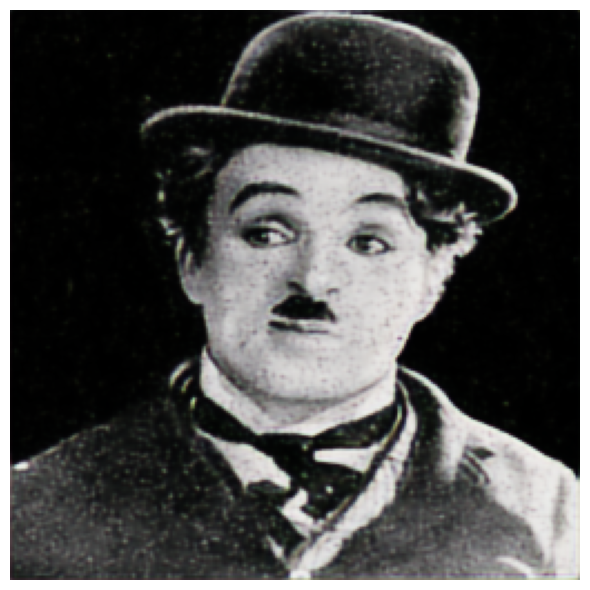

In [8]:
import matplotlib.pyplot as plt
from skimage.transform import resize  # Optional, for resizing if needed
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from skimage import img_as_float, io

# Load your custom image
custom_noisy_img = img_as_float(io.imread('/content/drive/MyDrive/pics/new_noisy_image.jpeg'))
custom_noisy_img = resize(custom_noisy_img[..., :3], (256, 256), anti_aliasing=True)
custom_noisy_img = np.expand_dims(custom_noisy_img, axis=0)  # Add batch dimension

# Predict denoised output
denoised_output = model.predict(custom_noisy_img)
denoised_output = denoised_output[0]  # Remove batch dimension

# Clip the output to be within [0, 1] to avoid any warnings during display
denoised_output = np.clip(denoised_output, 0, 1)

# Display only the denoised image
plt.figure(figsize=(6, 6))
plt.imshow(denoised_output)
plt.axis("off")
plt.tight_layout()
plt.show()


In [9]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from sklearn.metrics import mean_squared_error

# Function to evaluate the model using PSNR, SSIM, and MSE
def evaluate_model(model, noisy_imgs, clean_imgs):
    psnr_values = []
    ssim_values = []
    mse_values = []

    for i in range(len(noisy_imgs)):
        # Get a sample
        noisy_sample = noisy_imgs[i]
        clean_sample = clean_imgs[i]

        # Reshape the noisy sample for prediction
        noisy_sample_batch = np.expand_dims(noisy_sample, axis=0)

        # Predict using the trained model
        denoised_sample = model.predict(noisy_sample_batch)[0]

        # Calculate PSNR
        psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)

        # Calculate MSE
        mse = mean_squared_error(clean_sample.flatten(), denoised_sample.flatten())

        # Append the results
        psnr_values.append(psnr)
        mse_values.append(mse)

    # Average values
    avg_psnr = np.mean(psnr_values)
    avg_mse = np.mean(mse_values)

    return avg_psnr, avg_mse

# Example usage
avg_psnr, avg_mse = evaluate_model(model, noisy_imgs, clean_imgs)

print(f"Average PSNR: {avg_psnr:.2f} dB")
print(f"Average MSE: {avg_mse:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)


Average PSNR: 31.86 dB
Average MSE: 0.0008


<ipython-input-9-38536642de1e>:23: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = peak_signal_noise_ratio(clean_sample, denoised_sample)
